Data Cleaning<br>

Input File1: 'all_players.csv' for all players data <br>
Input File2: 'all_stars.csv' for all star players data <br>
Input File3: 'mvp_votings.csv' for voting data <br>
Input File4: 'mvp_votings_explanation.xlsx' refer as data dictionary <br>

Output File 1:'data_clean.csv' for cleaned data <br>

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm

#suppress warning messages
import sys
if not sys.warnoptions:
    import warnings    
    warnings.simplefilter('ignore')

C:\Users\Can SONG\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


Merge All Star and Vote Data

In [2]:
data = pd.read_csv('all_players.csv')
star = pd.read_csv('all_stars.csv')
star = star[star['season'] != 1980]
star['idx'] = star['player'] + '_' + star['season'].apply(str)
star = star.rename(index = star['idx']).drop('idx',axis=1)

#print out the name dismatch and replace it
star_list = star['player'].tolist()
data_list = data['player'].tolist()
print('Dismatch pair',set(star_list).difference(set(data_list)))

data['player'].replace('Goran Dragi??','Goran Dragic',inplace = True)
data['player'].replace('Luka Don??i??','Luka Doncic',inplace = True)
data['player'].replace('Manu Gin??bili','Manu Ginobili',inplace = True)
data['player'].replace('Nikola Joki??','Nikola Jokic',inplace = True)
data['player'].replace('Nikola Vu??evi??','Nikola Vucevic',inplace = True)
data['player'].replace('Peja Stojakovi??','Peja Stojakovic',inplace = True)

#remove first column
data = data[data.columns[1:]]
#reindex using name and season as index
data['idx'] = data['player'] + '_' + data['season'].apply(str)
data = data.rename(index = data['idx']).drop('idx',axis=1)

#get the performance data
vote = pd.read_csv('mvp_votings.csv')
#fix the season
for i in [81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]:
    vote['season'].replace(i,1900+i,inplace=  True)
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    vote['season'].replace(i,2000+i,inplace=  True)
#replace the name
vote['player'].replace('Goran Dragi??','Goran Dragic',inplace = True)
vote['player'].replace('Luka Don??i??','Luka Doncic',inplace = True)
vote['player'].replace('Manu Gin??bili','Manu Ginobili',inplace = True)
vote['player'].replace('Nikola Joki??','Nikola Jokic',inplace = True)
vote['player'].replace('Nikola Vu??evi??','Nikola Vucevic',inplace = True)
vote['player'].replace('Peja Stojakovi??','Peja Stojakovic',inplace = True)
vote['idx'] = vote['player'] + '_' + vote['season'].apply(str)
vote = vote.rename(index = vote['idx']).drop('idx',axis=1)
print('Have vote but not in all star:',len(set(vote['player'].tolist()).difference(set(star['player'].tolist()))))
print('In all star but not have vote:',len(set(star['player'].tolist()).difference(set(vote['player'].tolist()))))
#retain award_share
vote = vote[['player','award_share']]

Dismatch pair {'Manu Ginobili', 'Peja Stojakovic', 'Goran Dragic', 'Nikola Vucevic', 'Nikola Jokic', 'Luka Doncic'}
Have vote but not in all star: 31
In all star but not have vote: 97


In [3]:
#player from either all star or vote should be considered, and then use this as a criteria to reduce all players sample
#merge star and vote using left (using all star as critieria)
star_vote = pd.merge(star,vote,how = 'left',left_index = True,right_index = True)

#merge 3 datasets
data_star_vote = pd.merge(data,star_vote,how = 'inner',left_index = True,right_index = True)
data_star_vote['award_share'].fillna(0,inplace = True)
#drop useless columns
data_star_vote.drop(['player_x','player_y','season_y'],axis = 1,inplace = True)

#count the number of null value in each colmn
df = pd.DataFrame(data_star_vote.isnull().sum())
print(df[df[0]!=0])
#fill na with 0 (as na values are players without 3 points)
data_star_vote.fillna(0,inplace = True)

data = data_star_vote

      0
3p%  35


Check the merged data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933 entries, A.C. Green_1990 to Zydrunas Ilgauskas_2005
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       933 non-null    object 
 1   pos          933 non-null    object 
 2   age          933 non-null    int64  
 3   team         933 non-null    object 
 4   g            933 non-null    int64  
 5   mp           933 non-null    float64
 6   fg           933 non-null    float64
 7   fga          933 non-null    float64
 8   fg%          933 non-null    float64
 9   fg3          933 non-null    float64
 10  fg3a         933 non-null    float64
 11  3p%          933 non-null    float64
 12  efg          933 non-null    float64
 13  ft           933 non-null    float64
 14  fta          933 non-null    float64
 15  ft%          933 non-null    float64
 16  trb          933 non-null    float64
 17  ast          933 non-null    float64
 18  stl          933 non-

position

In [5]:
#having player with 2 positions
data['pos'].value_counts()

C        203
PG       195
SG       184
PF       182
SF       167
SF-SG      1
PG-SG      1
Name: pos, dtype: int64

In [6]:
#use one-hot encoding for position
#2 datapoints have PG-SG and SF-SG, both 2 fields will be filled by 1

#get dummy for categorical variable
pos_dummy = pd.get_dummies(data['pos'],prefix = 'pos')
#replace the 2 position cols & drop 2 position cols
for x in set(data['pos'].to_list()):
    if len(x)> 2:
        x1,x2 = x.split('-')
        pos_dummy.loc[pos_dummy[pos_dummy['pos_'+x] == 1].index,['pos_'+x1,'pos_'+x2]] = 1
        pos_dummy.drop(['pos_'+x],axis = 1,inplace = True)
#concat to original data and drop original position
data = pd.concat([data,pos_dummy],axis = 1)
data.drop('pos',axis = 1,inplace = True)

experience

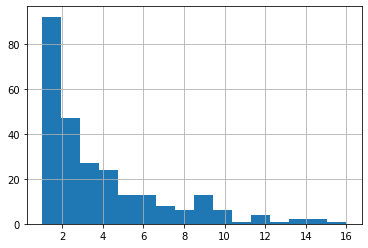

In [7]:
#how many years the player has been played
data['player'].value_counts().hist(bins = data['player'].value_counts().max())

In [8]:
#add column experience

#min_age = data.groupby(['player'])['age'].agg({'min':min})
min_age = data.groupby(['player'])['age'].min().rename('min')
data = pd.merge(data,min_age,on = 'player')
data['experience'] = data['age'] - data['min']
data.drop('min',axis = 1,inplace = True)

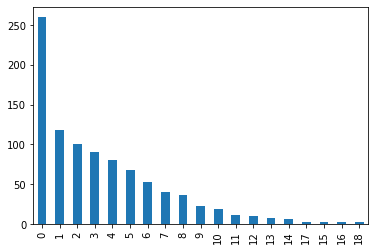

In [9]:
data['experience'].value_counts().plot.bar()

team_id

In [10]:
data['team'].value_counts()

BOS    60
LAL    59
SAS    50
DET    47
PHO    41
HOU    41
PHI    41
UTA    36
CHI    35
ATL    34
SEA    34
MIA    33
CLE    33
GSW    31
DAL    30
NYK    28
POR    27
MIL    26
DEN    24
IND    24
ORL    21
TOR    21
OKC    18
MIN    18
LAC    17
NJN    17
SAC    15
WAS    14
TOT    13
WSB     9
CHH     8
NOH     8
NOP     6
MEM     6
CHO     3
BRK     3
KCK     1
CHA     1
Name: team, dtype: int64

In [11]:
#get dummy for team categorical variable
team_dummy = pd.get_dummies(data['team'],prefix = 'team')
data = pd.concat([data,team_dummy],axis = 1)
data.drop('team',axis = 1,inplace = True)

performance index

Number of performance index 26


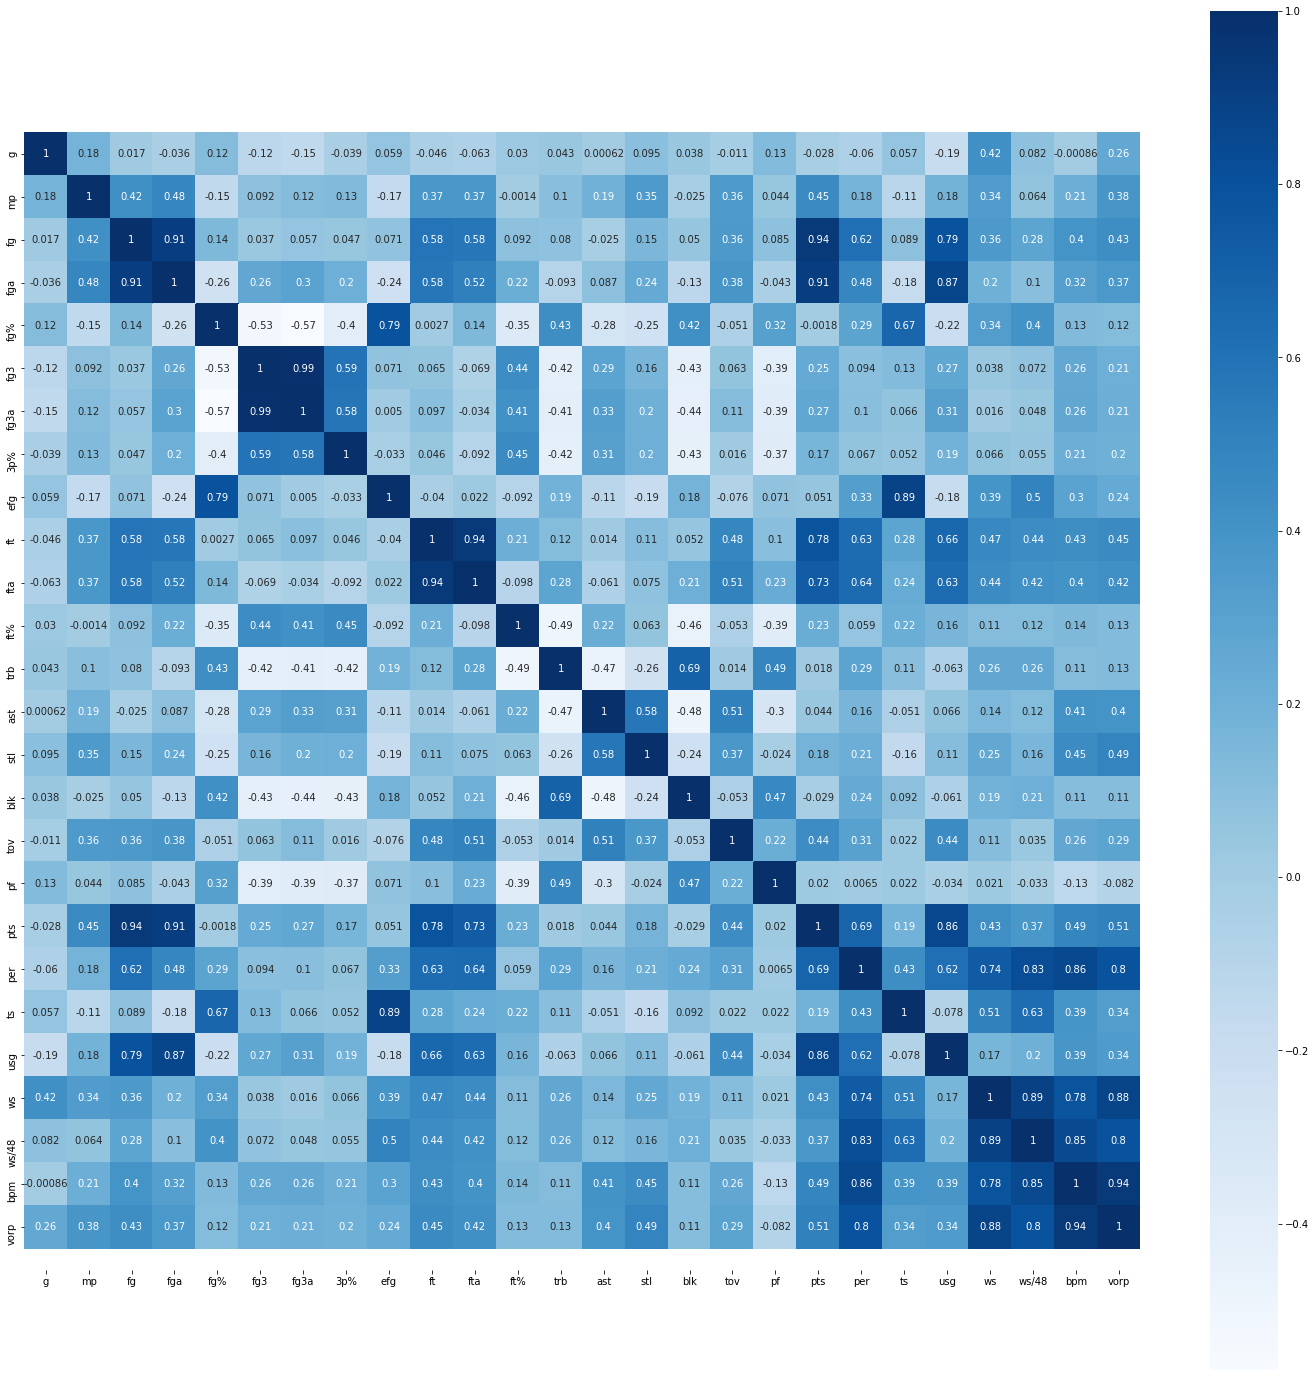

In [12]:
pf_col = [ 'g', 'mp', 'fg', 'fga', 'fg%', 'fg3', 'fg3a', '3p%','efg', 'ft', 'fta', 'ft%', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf','pts', 'per', 'ts', 'usg', 'ws', 'ws/48', 'bpm', 'vorp']
pf = data[pf_col]
print('Number of performance index',len(pf_col))
plt.subplots(figsize=(25, 25))
ax = sns.heatmap(pf.corr(),annot=True,square=True,cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [13]:
#some pair of index have index over 90% of correlation
corr_matrix = np.triu(pf.corr().values)
corr_list = []
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if corr_matrix[i,j] != 0 and corr_matrix[i,j] != 1:
            corr_list.append(corr_matrix[i,j])

In [14]:
c=pf.corr()
c=abs(c).where(np.triu(np.ones(c.shape), k=1).astype(np.bool)).unstack()
#sorted list of pairs with highest correlations: 
c=pd.DataFrame(list(c),list(c.axes[0])).dropna().sort_values([0],kind='mergesort',ascending=False).dropna()

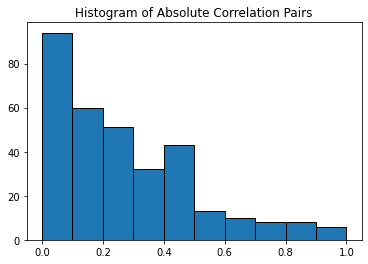

In [15]:
plt.hist(c.values,range = (0,1),bins = 10,edgecolor="black")
plt.title('Histogram of Absolute Correlation Pairs')
plt.show()

In [16]:
print(len(c),'pairs in total')
print(len(c[c > 0.95].dropna()),'pairs have correlation > 95%')
print(len(c[c > 0.90].dropna()),'pairs have correlation > 90%')
print(len(c[c > 0.8].dropna()),'pairs have correlation > 80%')
print(len(c[c > 0.7].dropna()),'pairs have correlation > 70%')
print(len(c[c > 0.6].dropna()),'pairs have correlation > 60%')

325 pairs in total
1 pairs have correlation > 95%
6 pairs have correlation > 90%
14 pairs have correlation > 80%
22 pairs have correlation > 70%
32 pairs have correlation > 60%


In [17]:
#remove the highly correlation pairs

#threshold for deleting one out of two
rth=0.8
#threshold for identifying highly corrlated variables
dth=0.6
nrow=data.shape[0]
#build list of X appearing in correlation > dth:
tn=[]
for x in list(c.index.values)[:min(nrow,max(5,sum(list((c>dth).iloc[:,0]))))]:
    tn=tn+(list(x))
#nx store the X appearing in correlation > dth
#cx store the number of X appearing in correlation > dth
nx=[]
cx=[]
for x in set(tn):
    nx.append(x)
    cx.append(tn.count(x))
#xvar ordered by times of appearance in correlations > dth:
tc=pd.DataFrame(cx,nx).sort_values(0, ascending=False)
#get the delete list
dl=[]
for i in range(sum(list((c>rth).iloc[:,0]))):
    d = list(c.index[i])[0] if tc.loc[list(c.index[i])[0],0] > tc.loc[list(c.index[i])[1],0] else list(c.index[i])[1]
    if not (d in dl):
        dl.append(d)
        print('\ncorr'+str(c.index[i]),'=',c.iloc[i,0])
        print("'"+d+"' is being deleted.")
#drop the variables in the delete list
print(dl)
for i in dl:
    data.drop(i,axis = 1,inplace = True)


corr('fg3a', 'fg3') = 0.9885990022809286
'fg3' is being deleted.

corr('fta', 'ft') = 0.9435510505416062
'ft' is being deleted.

corr('vorp', 'bpm') = 0.9416724027685673
'bpm' is being deleted.

corr('pts', 'fg') = 0.9354657934729911
'pts' is being deleted.

corr('fga', 'fg') = 0.9140313507459442
'fg' is being deleted.

corr('ws/48', 'ws') = 0.8941528392297602
'ws/48' is being deleted.

corr('ts', 'efg') = 0.8894139937168166
'ts' is being deleted.

corr('vorp', 'ws') = 0.8796404973536293
'ws' is being deleted.

corr('usg', 'fga') = 0.8678864268932455
'usg' is being deleted.

corr('bpm', 'per') = 0.858521292423488
'per' is being deleted.
['fg3', 'ft', 'bpm', 'pts', 'fg', 'ws/48', 'ts', 'ws', 'usg', 'per']


In [18]:
#new performance cols after deleting the ones with high correlation
pf_col = list(set(pf_col).difference(set(dl)))

Number of transformed index 16


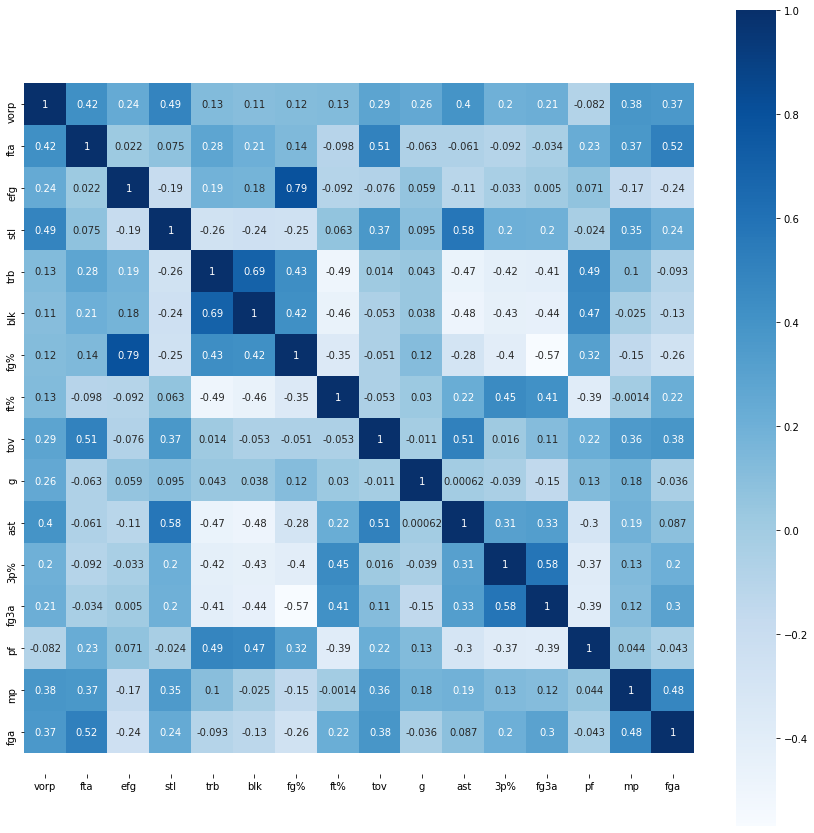

In [19]:
#visualize the matrix
pf = data[pf_col]
print('Number of transformed index',len(pf_col))
plt.subplots(figsize=(15, 15))
ax = sns.heatmap(pf.corr(),annot=True,square=True,cmap="Blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [21]:
#adding square and sqrt cols(having negative) to performance cols, age and experience
transform_col = pf_col
transform_col.extend(['age','experience'])

for i in transform_col:
    temp_i = i+'_rt'
    f = lambda x: -np.power(-x, 1./3) if x < 0 else np.power(x, 1./3)
    data[temp_i] = data[i].apply(f)
    temp_i = i+'_sq'
    data[temp_i] = np.power(data[i],3)

In [22]:
for i in range(len(transform_col)):
    transform_col.append(transform_col[i]+'_rt')
    transform_col.append(transform_col[i]+'_sq')

y-variable

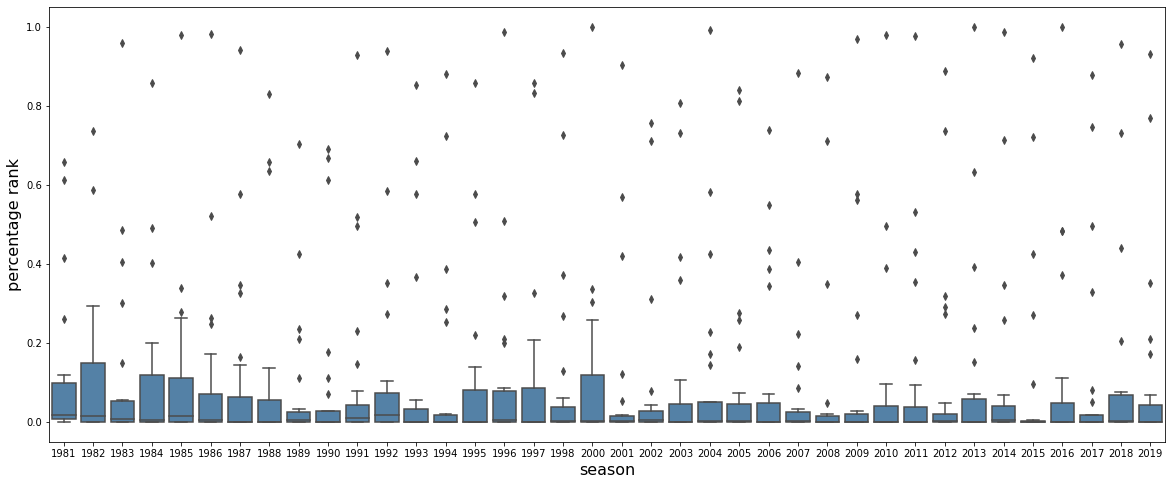

In [34]:
#draw the plot to see whether y variables change dramatically
plt.subplots(figsize=(20, 8))
sns.boxplot(x = 'season_x', y = 'award_share', data = data[data['season_x']<2020],color = 'steelblue')
plt.xlabel('season',fontsize = 16)
plt.ylabel('percentage rank',fontsize = 16)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [24]:
#check the percentage of obsrvations have 0 sample
len(data[data['award_share'] == 0])/len(data)

0.45980707395498394

In [28]:
#cleaned data
data.to_csv('data_clean.csv',index = False)